In [ ]:
import json
import re
import numpy as np
from collections import Counter
from sklearn.preprocessing import normalize
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import h5py
from scipy.sparse import lil_matrix
from numba import jit

In [ ]:
with open('/content/drive/MyDrive/NLP/clean_text_ext.json', 'r') as file:
    data = json.load(file)

In [ ]:
def tokenize_value(value):
    return re.findall(r'\b\w+\b', value.lower())

In [ ]:
def process_values_in_chunks(values_chunk):
    word_counter = Counter()
    for value in values_chunk:
        tokens = tokenize_value(value)
        word_counter.update(tokens)
    return word_counter

In [ ]:
def clean_value(value, top_vocab_set):
    tokens = tokenize_value(value)
    cleaned_tokens = [token for token in tokens if token in top_vocab_set]
    return ' '.join(cleaned_tokens)

In [ ]:
def clean_dictionary_and_get_top_vocab(input_dict, n_vocab=7000, n_chunks=50):
    values_list = list(input_dict.values())

    def chunkify(lst, n):
        chunk_size = len(lst) // n
        return [lst[i * chunk_size:(i + 1) * chunk_size] for i in range(n)] + [lst[n * chunk_size:]]

    chunks = chunkify(values_list, n_chunks)

    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_values_in_chunks, chunks), total=n_chunks, desc="Counting word frequencies"))

    final_word_counter = Counter()
    for result in results:
        final_word_counter.update(result)

    most_common_words = [word for word, _ in final_word_counter.most_common(n_vocab)]
    top_vocab_set = set(most_common_words)  # Set for quick lookup

    cleaned_dict = {}
    for key, value in tqdm(input_dict.items(), desc="Cleaning dictionary"):
        cleaned_value = clean_value(value, top_vocab_set)
        cleaned_dict[key] = cleaned_value

    return most_common_words, cleaned_dict

In [ ]:
top_7k_vocab, cleaned_dict = clean_dictionary_and_get_top_vocab(data, n_vocab=7000, n_chunks=50)

Counting word frequencies: 51it [02:08,  2.51s/it]                        
Cleaning dictionary: 100%|██████████| 56528/56528 [02:10<00:00, 434.01it/s]


In [ ]:
print("Top 7K Vocabulary:", top_7k_vocab[:10])

Top 7K Vocabulary: ['patients', 'covid', 'et', 'cells', 'al', 'virus', 'infection', 'study', 'disease', 'also']


In [ ]:
import pickle

In [ ]:
with open('/content/my_list.pkl', 'wb') as f:
    pickle.dump(top_7k_vocab, f)

In [ ]:
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

In [ ]:
vocab_index = {word: idx for idx, word in enumerate(top_7k_vocab)}

In [ ]:
vocab_size = len(top_7k_vocab)

In [ ]:
cooccurrence_matrix = lil_matrix((vocab_size, vocab_size), dtype=np.int32)

In [ ]:
for key, text in tqdm(cleaned_dict.items(), desc="Processing Keys"):
    tokens = tokenize(text)
    token_length = len(tokens)

    # Loop through tokens with a context window
    for i in range(token_length):
        if tokens[i] in vocab_index:
            target_index = vocab_index[tokens[i]]
            # Determine the range of context
            start = max(0, i - 4)  # context window of 4
            end = min(token_length, i + 4 + 1)  # +1 because the end is exclusive

            for j in range(start, end):
                if i != j and tokens[j] in vocab_index:  # skip the target token
                    context_index = vocab_index[tokens[j]]
                    cooccurrence_matrix[target_index, context_index] += 1

Processing Keys: 100%|██████████| 56528/56528 [4:27:38<00:00,  3.52it/s]


In [ ]:
cooccurrence_matrix = cooccurrence_matrix.tocsr()

with h5py.File('cooccurrence_matrix.h5', 'w') as hdf:
    hdf.create_dataset('cooccurrence_matrix', data=cooccurrence_matrix.toarray())

In [ ]:
def calc_weight_mat(dim, freq_mat):
    """Calculates the weight matrix by normalizing each row of the frequency matrix.
    For each word (row), it divides the co-occurrence counts by the row sum, resulting
    in probabilities of co-occurrence. """
    weight_mat = np.zeros((dim, dim), dtype=float)
    row_sums = np.sum(freq_mat, axis=1)

    for i in tqdm(range(dim)):
        if row_sums[i] != 0:  # Avoid division by zero
            weight_mat[i, :] = freq_mat[i, :] / row_sums[i]
    return weight_mat

def calc_co_occur_mat(dim, weight_mat):
    """This function calculates a co-occurrence matrix using the weight matrix.
    It identifies the context word with the highest probability (k) and computes
    the weighted co-occurrence score between words.    """
    co_mat = np.zeros((dim, dim), dtype=float)

    for j in tqdm(range(dim)):
        k = np.argmax(weight_mat[j, :])
        for i in range(dim):
            num = weight_mat[i, k]
            deno = weight_mat[j, k]
            if deno != 0:
                co_mat[i, j] = num / deno
    return co_mat

In [ ]:
# Load the co-occurrence matrix from HDF5
ramped_file_path = '/content/drive/MyDrive/NLP/cooccurrence_matrix.h5'

with h5py.File(ramped_file_path, 'r') as f:
    cooccurrence_matrix = np.array(f['cooccurrence_matrix'])

# Get the dimension of the matrix
dim = cooccurrence_matrix.shape[0]

# Calculate the weight matrix from the co-occurrence matrix
weight_matrix = calc_weight_mat(dim, cooccurrence_matrix)

# Calculate the co-occurrence matrix from the weight matrix
result_co_occur_matrix = calc_co_occur_mat(dim, weight_matrix)

# Save the resulting co-occurrence matrix to a file
with h5py.File('prob_cooccurrence_matrix.h5', 'w') as f:
     f.create_dataset('co_occurrence', data=result_co_occur_matrix)

100%|██████████| 7000/7000 [00:58<00:00, 118.95it/s]


In [ ]:
import nltk

# Download necessary data for POS tagging
nltk.download('averaged_perceptron_tagger')

# Function to find the POS tag
def get_pos(word):
    pos_tag = nltk.pos_tag([word])[0][1]  # Get the POS tag using NLTK
    return pos_tag

# Initialize empty lists for nouns and verbs
nouns = []
verbs = []

# Loop through the vocabulary until 5 nouns and 5 verbs are found
for word in top_7k_vocab:
    pos = get_pos(word)

    # Check for nouns (POS starting with 'NN')
    if pos.startswith('NN') and len(nouns) < 10:
        nouns.append(word)

    # Check for verbs (POS starting with 'VB')
    elif pos.startswith('VB') and len(verbs) < 10:
        verbs.append(word)

    # Stop once we have 5 nouns and 5 verbs
    if len(nouns) == 10 and len(verbs) == 10:
        break

print("First 10 Nouns:", nouns)
print("First 10 Verbs:", verbs)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


First 10 Nouns: ['patients', 'covid', 'et', 'cells', 'al', 'virus', 'infection', 'study', 'disease', 'data']
First 10 Verbs: ['using', 'used', 'associated', 'reported', 'based', 'infected', 'including', 'shown', 'compared', 'increased']


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define the target words for which you want to find the closest words
target_words = ['patients', 'covid', 'et', 'cells', 'al', 'virus', 'infection', 'study', 'disease', 'also']

# Find the indices of the target words in the vocabulary
target_indices = [top_7k_vocab.index(word) for word in target_words]

# Function to compute cosine similarity
def get_closest_words(word_index, matrix, top_n=5):
    # Get the vector of the target word
    word_vector = matrix[word_index].reshape(1, -1)

    # Compute cosine similarity between the target word and all other words
    similarities = cosine_similarity(word_vector, matrix).flatten()

    # Get the indices of the top N most similar words (excluding the word itself)
    most_similar_indices = similarities.argsort()[-top_n-1:-1][::-1]

    # Return the top N most similar words
    return [(top_7k_vocab[i], similarities[i]) for i in most_similar_indices]

# Compute the closest 5 words for each target word
for word in target_words:
    word_index = top_7k_vocab.index(word)
    closest_words = get_closest_words(word_index, result_co_occur_matrix, top_n=5)

    print(f"Closest words to '{word}':")
    for similar_word, similarity in closest_words:
        print(f"{similar_word}: {similarity:.4f}")
    print("\n")


Closest words to 'patients':
postmortem: 0.9889
autopsy: 0.9888
thrombosis: 0.9879
ct: 0.9876
mortality: 0.9875


Closest words to 'covid':
outpatients: 0.9919
comorbidities: 0.9916
stroke: 0.9903
among: 0.9898
hospitalization: 0.9895


Closest words to 'et':
zhou: 0.9257
zhao: 0.9247
zhu: 0.9243
zhang: 0.9233
kim: 0.9229


Closest words to 'cells':
macrophages: 0.9944
virusspecific: 0.9931
immature: 0.9930
apc: 0.9908
cytotoxic: 0.9904


Closest words to 'al':
liu: 0.9328
chen: 0.9328
li: 0.9309
huang: 0.9307
xu: 0.9298


Closest words to 'virus':
hsv: 0.9655
adenovirus: 0.9628
hav: 0.9603
canine: 0.9566
wnv: 0.9562


Closest words to 'infection':
isolation: 0.9477
circulation: 0.9388
highly: 0.9372
inhibitors: 0.9369
clearance: 0.9333


Closest words to 'study':
referring: 0.9802
overall: 0.9800
procedures: 0.9790
carefully: 0.9783
excluding: 0.9765


Closest words to 'disease':
diagnosing: 0.9774
treatments: 0.9714
designated: 0.9705
cure: 0.9703
syndromes: 0.9687


Closest words to

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

In [ ]:
with open('my_list.pkl', 'rb') as f:
    top_7k_vocab = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


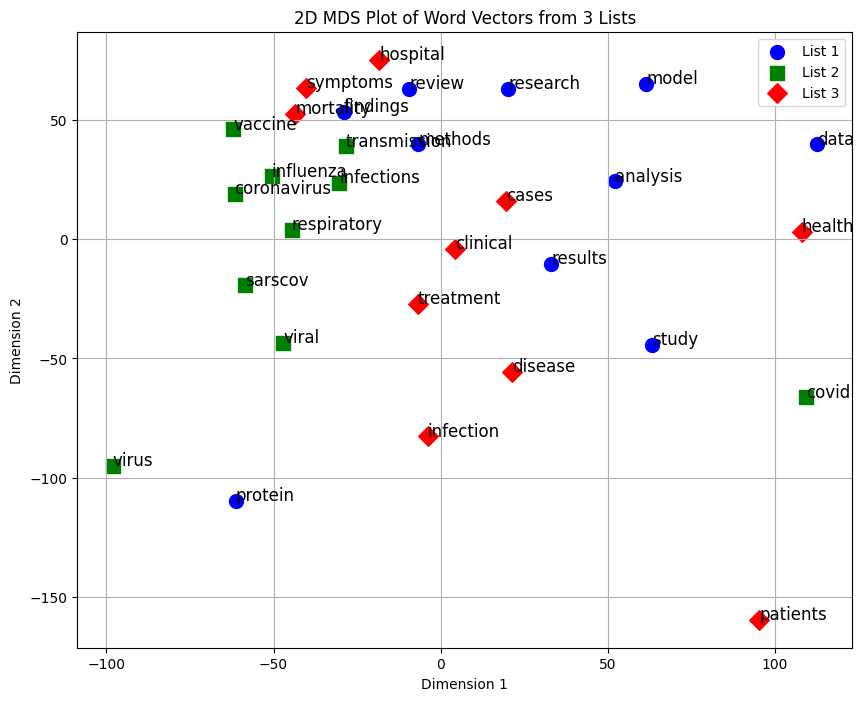

In [ ]:
# List of words (replace with actual words from your lists)
Medical = ["patients","infection","disease","treatment","cases","health","clinical","hospital","mortality","symptoms" ]
Virology = ["covid","virus","sarscov","viral","respiratory","coronavirus","transmission","infections","influenza","vaccine"]
Research = ["study","data","results","analysis","methods","model","research","protein","findings","review"]

#Social_Impact = ["lockdown", "confinement", "restrictions", "reopening", "panic"]
#viruses = ["ebov","ebv", "rsv", "reovirus", "fipv", "wnv","viral","respiratory","coronavirus"]
#Healthcare = ["hospitals", "symptoms", "treatment", "testing", "patients", "protocols","disease","treatment","cases","health"]
# Combine all lists for easy indexing
all_lists = [Research ,Virology ,Medical ]

# Find the indices of the words in the vocabulary
word_indices = [top_7k_vocab.index(word) for word_list in all_lists for word in word_list]

# Extract the corresponding co-occurrence vectors for the selected words
selected_vectors = cooccurrence_matrix[:, word_indices].T

# Optionally, standardize the data
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(selected_vectors)

# Perform MDS to reduce to 2 dimensions
mds = MDS(n_components=2, random_state=42)
reduced_vectors = mds.fit_transform(scaled_vectors)

# Assign different colors for each list
colors = ['blue', 'green', 'red']
markers = ['o', 's', 'D']  # Different marker shapes for each list

# Plot the words in 2D
plt.figure(figsize=(10, 8))

# Offset to manage different groups of words from lists
offset = 0
for i, word_list in enumerate(all_lists):
    list_size = len(word_list)

    # Plot the words from each list with a unique color and marker
    plt.scatter(reduced_vectors[offset:offset + list_size, 0], reduced_vectors[offset:offset + list_size, 1],
                color=colors[i], label=f'List {i+1}', s=100, marker=markers[i])

    # Add labels for the words
    for j, word in enumerate(word_list):
        plt.text(reduced_vectors[offset + j, 0] + 0.02, reduced_vectors[offset + j, 1] + 0.02, word, fontsize=12)

    # Update offset for the next list
    offset += list_size

# Plot customization
plt.title('2D MDS Plot of Word Vectors from 3 Lists')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()